In [2]:
# Imports
import os
import re
import string
import numpy as np
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding

In [3]:
# Load text
root = '../../data/task2/'

with open(root + 'train.en', 'r') as f:
    train_en = f.read().split('\n')
    
with open(root + 'train.hi', 'r') as f:
    train_hi = f.read().split('\n')
    
with open(root + 'dev.en', 'r') as f:
    dev_en = f.read().split('\n')
    
with open(root + 'dev.hi', 'r') as f:
    dev_hi = f.read().split('\n')
    
    
# Select first 40_000 lines
# Takes too long to train on larger data
SIZE = 40_000
train_en = train_en[:SIZE]
train_hi = train_hi[:SIZE]
    

# Preprocess
puncts = string.punctuation + train_hi[3][-1] # <-- Extra character is Hindi full stop

def clean_text(lines, english=True):
    clean_lines = []
    for line in lines:
        if english:
            # Doesn't make sense for hindi, so ...
            line = line.lower()
        line = line.translate(str.maketrans('', '', puncts))
        line = re.sub('\d+', '', line)
        # These tokens exist in some places in hindi text
        # Not sure if I've removed all of them
        line = re.sub('\u200b', '', line)
        line = re.sub('\u200d', '', line)
        
        clean_lines.append(line)
    return clean_lines

def prepare_lines(in_lines, out_lines):
    encoder_input, decoder_input, decoder_target = [], [], []
    for in_line, out_line in zip(in_lines, out_lines):
        encoder_input.append(in_line)
        decoder_input.append('startseq ' + out_line)
        decoder_target.append(out_line + ' endseq')
    return encoder_input, decoder_input, decoder_target


# Call the functions
train_en_clean = clean_text(train_en, True)
train_hi_clean = clean_text(train_hi, False)
dev_en_clean = clean_text(dev_en, True)
dev_hi_clean = clean_text(dev_hi, False)

train_encoder_input, train_decoder_input, train_decoder_target = prepare_lines(train_en_clean, train_hi_clean)
dev_encoder_input, dev_decoder_input, dev_decoder_target = prepare_lines(dev_en_clean, dev_hi_clean)

# Tokenize sequences
tokenizer_en = Tokenizer()
tokenizer_en.fit_on_texts(train_encoder_input + dev_encoder_input)
train_ei_seq = tokenizer_en.texts_to_sequences(train_encoder_input)
dev_ei_seq = tokenizer_en.texts_to_sequences(dev_encoder_input)
vocab_size_en = len(tokenizer_en.word_index) + 1
maxlen_en = max([len(s) for s in train_ei_seq + dev_ei_seq])

tokenizer_hi = Tokenizer()
tokenizer_hi.fit_on_texts(train_decoder_input + train_decoder_target + dev_decoder_input + dev_decoder_target)
train_di_seq = tokenizer_hi.texts_to_sequences(train_decoder_input)
train_dt_seq = tokenizer_hi.texts_to_sequences(train_decoder_target)
dev_di_seq = tokenizer_hi.texts_to_sequences(dev_decoder_input)
dev_dt_seq = tokenizer_hi.texts_to_sequences(dev_decoder_target)
vocab_size_hi = len(tokenizer_hi.word_index) + 1
maxlen_hi = max([len(s) for s in train_di_seq + train_dt_seq + dev_di_seq + dev_dt_seq])

# Pad sequences
train_ei_seq = pad_sequences(train_ei_seq, maxlen=maxlen_en, padding='post')
train_di_seq = pad_sequences(train_di_seq, maxlen=maxlen_hi, padding='post')
train_dt_seq = pad_sequences(train_dt_seq, maxlen=maxlen_hi, padding='post')

dev_ei_seq = pad_sequences(dev_ei_seq, maxlen=maxlen_en, padding='post')
dev_di_seq = pad_sequences(dev_di_seq, maxlen=maxlen_hi, padding='post')
dev_dt_seq = pad_sequences(dev_dt_seq, maxlen=maxlen_hi, padding='post')

In [4]:
# Data generator
def data_generator(encoder_input, decoder_input, decoder_target, out_vocab_size, batch_size):
    enc_in, dec_in, dec_trg = [], [], []
    count = 0
    while True:
        for x1, x2, y in zip(encoder_input, decoder_input, decoder_target):
            enc_in.append(x1)
            dec_in.append(x2)
            dec_trg.append(to_categorical(y, num_classes=out_vocab_size))
            count += 1
            if count == batch_size:
                yield ([np.array(enc_in), np.array(dec_in)], np.array(dec_trg))
                enc_in, dec_in, dec_trg = [], [], []
                count = 0

In [5]:
# Building the model

latent_dim = 256  # Dimension of hidden layer of LSTM

# Encoder
# Will generate the starting hidden state (h and c) for the decoder 
encoder_input = Input(shape=(maxlen_en,))
encoder_embedding = Embedding(vocab_size_en, latent_dim, input_length=maxlen_en, mask_zero=True)(encoder_input)
_, encoder_state_h, encoder_state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
encoder_states = [encoder_state_h, encoder_state_c]
# Shape (1, 256) each

# Decoder
# Initialized with hidden state from encoder
# Input is token at timestep t and target is token at timestep t+1 ...
# ... until end token or maximum length is reached
decoder_input = Input(shape=(maxlen_hi,))
decoder_embedding = Embedding(vocab_size_hi, latent_dim, input_length=maxlen_hi, mask_zero=True)(decoder_input)
decoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=True)
decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
# Shape of output -> (batch_size, output_timesteps, output_vocab_size)

# Dense layer to generate softmax probabilities for each token in output vocabulary
decoder_dense = Dense(vocab_size_hi, activation='softmax')
decoder_output = decoder_dense(decoder_output)

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [81]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 40, 256)      1950208     input_27[0][0]                   
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 38, 256)      2173696     input_28[0][0]                   
____________________________________________________________________________________________

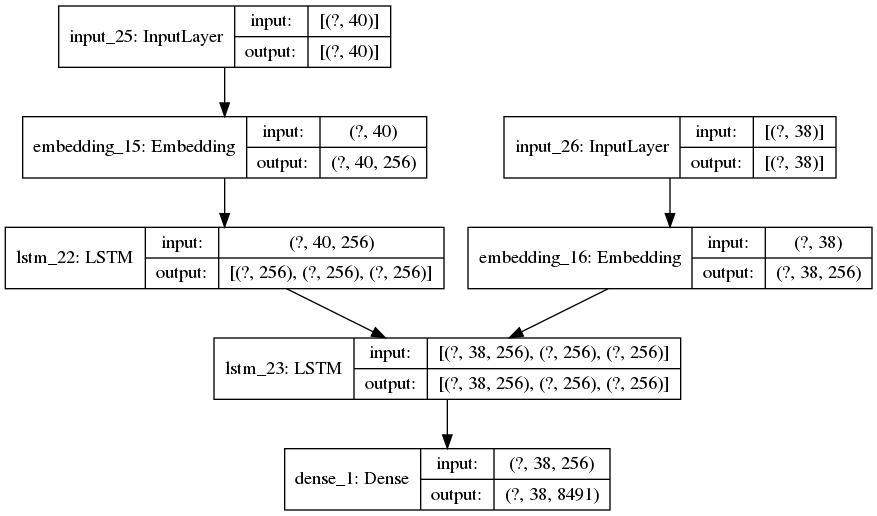

In [70]:
plot_model(model, show_shapes=True)

In [78]:
# Training the model

epochs = 20
batch_size = 10
steps = len(train_ei_seq) // batch_size
save_root = '../../data/task2/checkpoints/'

for epoch in tqdm(range(epochs)):
    datagen = data_generator(train_ei_seq, train_di_seq, train_dt_seq, vocab_size_hi, batch_size)
    model.fit_generator(datagen, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(save_root + f'machine_translation_{epoch}.h5')


  0%|          | 0/20 [00:00<?, ?it/s]

1000/1000 [==============================] - 287s 287ms/step - loss: 1.1346



  5%|▌         | 1/20 [04:48<1:31:23, 288.61s/it]

1000/1000 [==============================] - 277s 277ms/step - loss: 0.9754



 10%|█         | 2/20 [09:27<1:25:39, 285.55s/it]

1000/1000 [==============================] - 272s 272ms/step - loss: 0.8641



 15%|█▌        | 3/20 [14:00<1:19:50, 281.80s/it]

1000/1000 [==============================] - 270s 270ms/step - loss: 0.7601



 20%|██        | 4/20 [18:31<1:14:19, 278.72s/it]

1000/1000 [==============================] - 268s 268ms/step - loss: 0.6645



 25%|██▌       | 5/20 [23:00<1:08:56, 275.79s/it]

1000/1000 [==============================] - 267s 267ms/step - loss: 0.5757



 30%|███       | 6/20 [27:28<1:03:46, 273.34s/it]

1000/1000 [==============================] - 266s 266ms/step - loss: 0.4958



 35%|███▌      | 7/20 [31:55<58:50, 271.55s/it]  

1000/1000 [==============================] - 278s 278ms/step - loss: 0.4253



 40%|████      | 8/20 [36:34<54:44, 273.67s/it]

1000/1000 [==============================] - 273s 273ms/step - loss: 0.3642



 45%|████▌     | 9/20 [41:07<50:10, 273.68s/it]

1000/1000 [==============================] - 275s 275ms/step - loss: 0.3111



 50%|█████     | 10/20 [45:43<45:43, 274.31s/it]

1000/1000 [==============================] - 274s 274ms/step - loss: 0.2638



 55%|█████▌    | 11/20 [50:18<41:11, 274.56s/it]

1000/1000 [==============================] - 273s 273ms/step - loss: 0.2236



 60%|██████    | 12/20 [54:52<36:34, 274.27s/it]

1000/1000 [==============================] - 272s 272ms/step - loss: 0.1884



 65%|██████▌   | 13/20 [59:25<31:56, 273.83s/it]

1000/1000 [==============================] - 273s 273ms/step - loss: 0.1587



 70%|███████   | 14/20 [1:03:59<27:23, 273.84s/it]

1000/1000 [==============================] - 271s 271ms/step - loss: 0.1318



 75%|███████▌  | 15/20 [1:08:31<22:46, 273.36s/it]

1000/1000 [==============================] - 271s 271ms/step - loss: 0.1096



 80%|████████  | 16/20 [1:13:03<18:11, 272.91s/it]

1000/1000 [==============================] - 272s 272ms/step - loss: 0.0918



 85%|████████▌ | 17/20 [1:17:35<13:38, 272.85s/it]

1000/1000 [==============================] - 271s 271ms/step - loss: 0.0779



 90%|█████████ | 18/20 [1:22:08<09:05, 272.72s/it]

1000/1000 [==============================] - 265s 265ms/step - loss: 0.0640



 95%|█████████▌| 19/20 [1:26:34<04:30, 270.63s/it]

1000/1000 [==============================] - 264s 264ms/step - loss: 0.0532



100%|██████████| 20/20 [1:30:59<00:00, 272.96s/it]


# Prediction

In [6]:
# Load pretrained model
# Model was trained on Google Colab with GPU

ckpt_path = '../../data/task2/checkpoints/'
model = load_model(ckpt_path + 'machine_translation_19.h5')

In [41]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 54)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 51)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 54, 256)      3814912     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 51, 256)      4377856     input_8[0][0]                    
____________________________________________________________________________________________

In [40]:
decoder_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 51)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 51, 256)      4377856     input_2[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [51]:
# Prediction model

# Generate starting h and c for input sequence
# Same weights from trained model
encoder_model = Model(encoder_input, encoder_states)

# Inputs are hidden state from encoder model
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Take in an input token (padded), generate embedding ...
# ... predict output sequence and hidden states
# Next token in output sequence is the input and ...
# ... hidden states are previous hidden states from decoder LSTM 
decoder_embed = Embedding(vocab_size_hi, latent_dim, input_length=maxlen_hi, mask_zero=True)(decoder_input) 
decoder_output, state_h, state_c = decoder_lstm(decoder_embed, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_output = decoder_dense(decoder_output)

decoder_model = Model(
    [decoder_input] + decoder_states_inputs,
    [decoder_output] + decoder_states
)

# If loading pretrained model (name = model) 
# Use these parts to set weights of prediction model
# If using immediately after training the model, comment this part out
encoder_model.layers[1].set_weights(model.layers[2].get_weights())
encoder_model.layers[2].set_weights(model.layers[4].get_weights())

decoder_model.layers[1].set_weights(model.layers[3].get_weights())
decoder_model.layers[-2].set_weights(model.layers[-2].get_weights())
decoder_model.layers[-1].set_weights(model.layers[-1].get_weights())

In [36]:
# Index to word decoder dictionaries
# Generate by reversing tokenizer word_index

idx2word_en = {i: word for word, i in tokenizer_en.word_index.items()}
idx2word_hi = {i: word for word, i in tokenizer_hi.word_index.items()}

In [37]:
# Decoding functions

def decode_sequence(input_seq):
    encoder_states = encoder_model(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_hi.word_index['startseq']
    
    stop_condition = False
    words = []
    while not stop_condition:
        # Get the sequence of outputs and hidden states
        output_tokens, h, c = decoder_model.predict([target_seq] + encoder_states)
        # Maximum probability index as prediction
        pred = np.argmax(output_tokens[0, -1, :])
        # Find the correct word and append it in list of words
        word = idx2word_hi[pred]
        words.append(word)
        
        # If end token encountered or maximum length reached, break 
        if word == 'endseq' or len(words) == maxlen_hi:
            stop_condition = True
        
        # Next input is current prediction
        # Next hidden states are hidden states of this prediction
        target_seq[0, 0] = pred
        encoder_states = [h, c]
    
    return ' '.join(words[:-1])

In [38]:
def test_model(dev_seq, dev_sentences, num_samples):
    
    """
    Randomly chooses num_samples number of sentences from 
    development set and translates.
    """
    
    idx = np.random.choice(np.arange(0, len(dev_seq)), size=num_samples, replace=False)
    in_seq = dev_seq[idx]
    in_sentences = np.array(dev_sentences)[idx].tolist()
    
    for seq, eng_sentence in zip(in_seq, in_sentences):
        translation = decode_sequence(seq.reshape(1, -1))
        print("[ENGLISH] \t {}".format(eng_sentence))
        print("[HINDI] \t {}".format(translation))
        print("\n------------------------------------------------\n")

In [50]:
test_model(dev_ei_seq, dev_en_clean, num_samples=5)

[ENGLISH] 	 why dont you start right now and get the fuck out of here
[HINDI] 	 चोटी कार में जाओ लेकिन मैं कैसे एक चुंबन शुभरात्रि दे

------------------------------------------------

[ENGLISH] 	 nasas eos satellites pinged the anomaly first the ice shelf plays hell on the echo soundings
[HINDI] 	 ताजा केले के रूप में ज्ञान लाइन में जाग रहा है कल्पना की ओर

------------------------------------------------

[ENGLISH] 	 after  days of sleep sounds like youre ready to go
[HINDI] 	 कई साल प्राणी बनाई है साइकिल जो वे तारकोल से दबा अगर

------------------------------------------------

[ENGLISH] 	 eightythousand people on their feet watching this ball sail through the air
[HINDI] 	 बैठक ग्रह जब हमारे लक्ष्य नेता जो से कोई बदलाव ले सकता है

------------------------------------------------

[ENGLISH] 	 next time they shine your light in the sky dont go to it
[HINDI] 	 वे अपनी बंदूकें डेटा बेचने अपनी उंगलियों पर अपने काम करते हैं

------------------------------------------------

